In [395]:
import pandas as pd
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,TfidfTransformer
from sklearn.svm import SVC,LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score,precision_recall_fscore_support,classification_report
from sklearn.decomposition import PCA

stopwords = stopwords.words('english')

## 1. preprocessing

In [396]:
# getting the extracted news as df
data = pd.read_csv('extracted_data.csv').drop('Unnamed: 0', axis=1)
data.columns = ['url','section','location','headline','text','label']

In [397]:
# merging headline and content as another column and create another dataframe with jusst text and label.
df = pd.DataFrame([data.headline+". "+data.text,data.label]).transpose()
df.columns = ['text','label']

In [398]:
# here is the text
df.text

0      Readers mail. SC ruling on alimony The Supreme...
1      Niqaab is ‘the elephant in the courtroom’, say...
2      Grandparents honoured. Staff and students of G...
3      Fishermen call off strike. The country boat fi...
4      Badal meets PM, seeks clemency for Bhullar. Pu...
                             ...                        
576    Profit not his motive. Taking cue from the sch...
577    Music concert. A musical tribute to legendary ...
578    Blind pursuit. The audience is tired of watchi...
579    Pakistan kills 31 militants in airstrikes. Pak...
580    Centre to hold talks to end Manipur crisis. Th...
Name: text, Length: 581, dtype: object

In [399]:
# preprocessing function 
    # split an article into sentences
        # go to each sentence and split it to words
            # if this word  is not in stopwords or other common words I've decided
                #AND
                   # if its alphabetic (getting rid of puctuation and numbers)
                        #AND
                            # if len of the word is greater than 2
                            
                            # lemmatize and lowercase the the word
                            
                            # return the cleaned article
def preprocess(news):
    l = WordNetLemmatizer()
    sentences = news.split(".")
    return " ".join([l.lemmatize(word.lower()) for sentence in sentences for word in sentence.split() if word not in stopwords if word.isalpha() if len(word)> 2 if word.lower() not in ["said","the","first","also","would","one","two","they"]])

In [400]:
# apply preprocess() function to each article
df['text'] = df['text'].map(preprocess)

In [401]:
df.text

0      reader mail ruling alimony supreme court exten...
1      niqaab elephant say judge person may give evid...
2      grandparent honoured staff student global publ...
3      fisherman call strike country boat fisherman l...
4      badal meet seek clemency bhullar punjab chief ...
                             ...                        
576    profit motive taking cue scheme implemented st...
577    music concert musical tribute legendary mystic...
578    blind pursuit audience tired watching actor pl...
579    pakistan kill militant airstrikes pakistani ai...
580    centre hold talk end manipur crisis centre dec...
Name: text, Length: 581, dtype: object

##### **Our data is ready to be fed into vectorizers.**

## 2. exploratory data analysis

### 2.1 word freqs

In [402]:
# getting protest and not_protest news
protest_news = df[df.label == 1].text
not_protest_news = df[df.label == 0].text

In [403]:
# freq function:
    # this function will return the first_n frequent words with their ratio in a giving list of articles

def give_freqs(list_of_articles,first_n=10):
    freqs = {}
    for n in list_of_articles:
        words = set(n.split())

        for w in words:
            if w not in freqs:
                freqs[w] = 1
            else:
                freqs[w] += 1

    f = [(freqs[w]/len(list_of_articles),w) for w in freqs]
    f.sort(reverse=True)

    return f[:first_n]

In [404]:
give_freqs(protest_news,10)

[(0.4383561643835616, 'district'),
 (0.4315068493150685, 'government'),
 (0.4246575342465753, 'state'),
 (0.3972602739726027, 'protest'),
 (0.3698630136986301, 'police'),
 (0.2808219178082192, 'leader'),
 (0.2671232876712329, 'minister'),
 (0.2671232876712329, 'member'),
 (0.2465753424657534, 'demanding'),
 (0.23972602739726026, 'staged')]

In [405]:
give_freqs(not_protest_news,10)

[(0.2735632183908046, 'government'),
 (0.2482758620689655, 'year'),
 (0.23908045977011494, 'state'),
 (0.22528735632183908, 'take'),
 (0.21379310344827587, 'time'),
 (0.20689655172413793, 'people'),
 (0.20689655172413793, 'new'),
 (0.20689655172413793, 'minister'),
 (0.20229885057471264, 'day'),
 (0.19080459770114944, 'india')]

##### These two list has some common words with different ratios lets get what are the differences in the top 10 words

In [406]:
protest_words = set([i[1] for i in give_freqs(protest_news,10)])-set([i[1] for i in give_freqs(not_protest_news,10)])

# these are protest words which are not in not_protest words
protest_words

{'demanding', 'district', 'leader', 'member', 'police', 'protest', 'staged'}

In [407]:
not_protest_words= set([i[1] for i in give_freqs(not_protest_news,10)])-set([i[1] for i in give_freqs(protest_news,10)])
# same for the not_protest news
not_protest_words

{'day', 'india', 'new', 'people', 'take', 'time', 'year'}

### 2.2 word affects & distinctive words

##### Now, lets figure of what a single word can tell us about articles

#### "protest" affect:

as it can be seen on the word freqs "protest" is exists in the ~40% of the protest news and it does not exist on the not_protest news.

In [98]:
# bayes theorem. 
    # finding the probability for being protest or not protest for an article which includes given word
def word_affect(word):
    number_of_occurance_in_protest_list = 0
    for article in protest_news:
        for w in article.split():
            if w == word:
                number_of_occurance_in_protest_list +=1
                break 
                
    number_of_occurance_in_not_protest_list = 0
    for article in not_protest_news:
        for w in article.split():
            if w == word:
                number_of_occurance_in_not_protest_list +=1
                break       

    
    pi1 = len(protest_news)/(len(protest_news)+len(not_protest_news))
    pi2 = len(not_protest_news)/(len(protest_news)+len(not_protest_news))
    fkx = number_of_occurance_in_protest_list/len(protest_news)
    fkx_ = number_of_occurance_in_not_protest_list/len(not_protest_news)
    prob = (pi1*fkx)/((pi1*fkx)+(pi2*fkx_))
    
    
    #returns (probability of protest, probability of not protest)
        # this is might seem counterintutitive with word freqs but we must remember the ratio of news
    return(prob,1-prob)

In [116]:
word_affect("protest")

(0.7532467532467533, 0.24675324675324672)

In [117]:
word_affect("holiday")

(0.22222222222222224, 0.7777777777777778)

In [119]:
word_affect("police")

(0.4864864864864864, 0.5135135135135136)

### 2.3 class disturbition

0    435
1    146
Name: label, dtype: int64


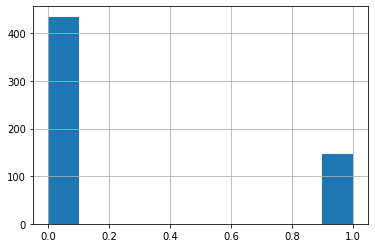

In [408]:
print(df.label.value_counts())
df.label.hist()

- as it can be seen from the histogram, we have **unbalanced** data with ~25%,75% ratios.
- this may cause some problems such as;
    - focusing on wrong metrics, like accuracy, may mislead us. since, 75% of the data is 'class 0', if our model will label all the dataset as 'class 0', we'll get 75% accuracy.

##### I will first try some algorithms on whole dataset and then try to handle the "unbalanced data" problem withh under-sampling

## 3. Training on Whole Data

### 3.1 prepare data

In [409]:
articles = df.text
labels = df.label

In [410]:
# Vectorize the text
vectorizer = TfidfVectorizer(min_df= 4, ngram_range=(1, 2))

In [411]:
tfidf_articles = vectorizer.fit_transform(articles).toarray().astype('float64')

In [412]:
tfidf_dataframe = pd.DataFrame(tfidf_articles)
tfidf_dataframe.reset_index().drop('index',axis=1)
y = pd.DataFrame(labels).astype('float64').label

In [413]:
tfidf_dataframe.shape,y.shape

((581, 3390), (581,))

In [177]:
trainx,testx,trainy,testy = train_test_split(tfidf_dataframe,y,test_size=0.3,shuffle=True,random_state=22)

### 3.2 GridSearch for Algorithms

#### 3.2.1 Logistic Regression

In [178]:
logistic_model = LogisticRegression()


hyperparameters = dict(C= np.logspace(0, 4, 10),
                       penalty = ['l2'],
                       class_weight = [{1:1,0:1},{1:2,0:1},{1:3,0:0.5}])

logistic_grid = GridSearchCV(logistic_model, hyperparameters, cv=5,scoring='f1_macro')

best_logistic = logistic_grid.fit(trainx, trainy)

best_logistic.best_score_

In [189]:
best_logistic.best_params_

{'C': 7.742636826811269, 'class_weight': {1: 3, 0: 0.5}, 'penalty': 'l2'}

__Test Scores For LogisticRegression()__

In [190]:
print(classification_report(best_logistic.predict(testx),testy))

              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94       126
         1.0       0.90      0.78      0.84        49

    accuracy                           0.91       175
   macro avg       0.91      0.87      0.89       175
weighted avg       0.91      0.91      0.91       175



#### 3.2.2 Support Vector Classifier

In [191]:
svc_model = SVC()

hyperparameters= dict(kernel=["linear", "poly","sigmoid"],
                      C=np.logspace(0, 4, 10), 
                      class_weight=[{1:1,0:1},{1:2,0:1},{1:3,0:0.5}])

svc_grid = GridSearchCV(svc_model, hyperparameters, cv=5,scoring='f1_macro')

best_svc = svc_grid.fit(trainx,trainy)

best_svc.best_score_

In [202]:
best_svc.best_params_

{'C': 1.0, 'class_weight': {1: 3, 0: 0.5}, 'kernel': 'linear'}

___Test Scores For SVC()___ 

In [203]:
print(classification_report(best_svc.predict(testx),testy))

              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94       127
         1.0       0.88      0.77      0.82        48

    accuracy                           0.91       175
   macro avg       0.90      0.87      0.88       175
weighted avg       0.91      0.91      0.91       175



On this settings, Logistic Regression is doing slighlty better than SVC

##### Now, let's try same procedure for Under-Sampled Data

## 4. Trainin on Under-Sampled Data

### 4.1 prepare data

In [205]:
DATA = pd.concat([tfidf_dataframe,y],axis=1)

In [206]:
undersampled_DATA = pd.concat([DATA[DATA.label == 0].sample(146),DATA[DATA.label==1]],ignore_index=True)

1.0    146
0.0    146
Name: label, dtype: int64


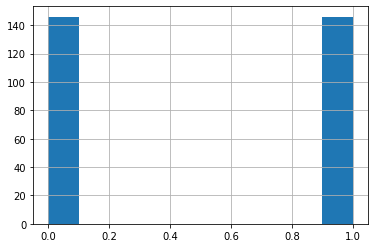

In [212]:
print(undersampled_DATA.label.value_counts())
undersampled_DATA.label.hist()

###### we achieved the balance by sacrificing on almost half of our data

In [217]:
uns_x = undersampled_DATA.iloc[:,:-1]
uns_y = undersampled_DATA.iloc[:,-1]

In [218]:
trainx,testx,trainy,testy = train_test_split(uns_x,uns_y,test_size=0.3,shuffle=True,random_state=22)

### 4.2 GridSearch for Algorithms

#### 4.2.1 Logistic Regression

In [219]:
logistic_model = LogisticRegression()


hyperparameters = dict(C= np.logspace(0, 4, 10),
                       penalty = ['l2'],
                       class_weight = [{1:1,0:1},{1:2,0:1},{1:3,0:0.5}])

logistic_grid = GridSearchCV(logistic_model, hyperparameters, cv=5,scoring='f1_macro')

best_logistic = logistic_grid.fit(trainx, trainy)

best_logistic.best_score_

0.8564778001800128

In [220]:
best_logistic.best_params_

{'C': 59.94842503189409, 'class_weight': {1: 1, 0: 1}, 'penalty': 'l2'}

__Test Scores For LogisticRegression()__

In [221]:
print(classification_report(best_logistic.predict(testx),testy))

              precision    recall  f1-score   support

         0.0       0.97      0.90      0.94        41
         1.0       0.92      0.98      0.95        47

    accuracy                           0.94        88
   macro avg       0.95      0.94      0.94        88
weighted avg       0.95      0.94      0.94        88



#### 4.2.2 Support Vector Classifier

In [222]:
svc_model = SVC()

hyperparameters= dict(kernel=["linear", "poly","sigmoid"],
                      C=np.logspace(0, 4, 10), 
                      class_weight=[{1:1,0:1},{1:2,0:1},{1:3,0:0.5}])

svc_grid = GridSearchCV(svc_model, hyperparameters, cv=5,scoring='f1_macro')

best_svc = svc_grid.fit(trainx,trainy)

best_svc.best_score_

0.8474970493391547

In [223]:
best_svc.best_params_

{'C': 1.0, 'class_weight': {1: 2, 0: 1}, 'kernel': 'linear'}

__Test Scores For SVC()__

In [224]:
print(classification_report(best_svc.predict(testx),testy))

              precision    recall  f1-score   support

         0.0       0.95      0.90      0.92        40
         1.0       0.92      0.96      0.94        48

    accuracy                           0.93        88
   macro avg       0.93      0.93      0.93        88
weighted avg       0.93      0.93      0.93        88



#### With under-sampled data, I am getting better results and LogisticRegression is giving slightly better results than SVC()

### PCA

##### working on this part but seems like will not work! dont worry about here

In [429]:
pca = PCA(n_components=10)
pca_X = pd.DataFrame(pca.fit_transform(tfidf_dataframe))
print (tfidf_dataframe.shape,pca_X.shape)
sum(pca.explained_variance_ratio_)

(581, 3390) (581, 10)


0.0735296125282273

In [430]:
import torch
import torch.tensor as tensor
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix

In [431]:
x_tr,x_te,y_tr,y_te = train_test_split(pca_X.to_numpy(),y.to_numpy(),test_size=0.2,random_state=44)

x_train = torch.from_numpy(x_tr).float()
y_train = torch.from_numpy(y_tr).float().view(len(y_tr),1)

x_test = torch.from_numpy(x_te).float()
y_test = torch.from_numpy(y_te).float().view(len(y_te),1)

AttributeError: 'Tensor' object has no attribute 'to_numpy'

In [432]:
x_train.shape,y_train.shape,x.dtype,y.dtype

(torch.Size([464, 30]), torch.Size([464, 1]), torch.float32, torch.float32)

In [418]:
def plot_losses(t,e):
    plt.plot(range(len(t)),t,color="r")
    plt.plot(range(len(t)),e,color="b")

In [419]:
import random
shuffled_idx = [i for i in range(len(y_train))]
random.shuffle(shuffled_idx)

batch_size = 58

batches = []
for i in range(0,len(y_train),batch_size):

    indices= [shuffled_idx[i:i+batch_size]]

    batches.append([x_train[indices],y_train[indices]])

In [420]:
batches[0][0].shape,batches[0][1].shape

(torch.Size([58, 30]), torch.Size([58, 1]))

In [421]:
class ProtestClassifier(nn.Module):
    def __init__(self):
        super(ProtestClassifier,self).__init__()
        
        self.layer1 = nn.Linear(x.shape[1],64)
        self.drop1 = nn.Dropout(p=0.2)
        self.layer2 = nn.Linear(64,32)
        self.drop2 = nn.Dropout(p=0.2)
        self.layer3= nn.Linear(32,1)
        
    def forward(self,x):
        
        x = self.layer1(x)
        x = torch.tanh(x)
        x = self.drop1(x)
        x = self.layer2(x)
        x = torch.tanh(x)
        x = self.drop2(x)
        x = self.layer3(x)
        x = torch.sigmoid(x)

        return x
        
    def predict(self,x):
        pred = torch.sigmoid(self.forward(x))
        ans = []
        for t in pred:
            if t[0]>0.500001:
                ans.append(1)
            else:
                ans.append(0)
        return torch.tensor(ans)

In [426]:
#Initialize the model
model = ProtestClassifier()
#Define loss criterion
criterion = nn.BCEWithLogitsLoss()
#Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [428]:
#Number of epochs
epochs = 361
#List to store losses
trn_losses = []
eval_losses = []
for i in range(1,epochs):
    for batch in batches:
        x = batch[0]
        y = batch[1]
        
        y_pred = model.forward(x)
        loss = criterion(y_pred,y)    

      
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if i % 20 == 0:
        evalloss = criterion(model.forward(x_test),y_test)
        print(i,'\t',"Training Loss:",round(loss.item(),4),"Eval Loss:",round(evalloss.item(),4))
        trn_losses.append(round(loss.item(),4))
        eval_losses.append(round(evalloss.item(),4))

evalloss = criterion(model.forward(x_test),y_test)
print("\n\nTraining Loss:",round(loss.item(),4),"Eval Loss:",round(evalloss.item(),4))

20 	 Training Loss: 0.6752 Eval Loss: 0.6529
40 	 Training Loss: 0.6752 Eval Loss: 0.6528
60 	 Training Loss: 0.6752 Eval Loss: 0.6527
80 	 Training Loss: 0.6752 Eval Loss: 0.6528
100 	 Training Loss: 0.6752 Eval Loss: 0.6527
120 	 Training Loss: 0.6752 Eval Loss: 0.6528
140 	 Training Loss: 0.6752 Eval Loss: 0.6527
160 	 Training Loss: 0.6752 Eval Loss: 0.6528
180 	 Training Loss: 0.6752 Eval Loss: 0.6527
200 	 Training Loss: 0.6752 Eval Loss: 0.6528
220 	 Training Loss: 0.6752 Eval Loss: 0.653
240 	 Training Loss: 0.6752 Eval Loss: 0.6527
260 	 Training Loss: 0.6752 Eval Loss: 0.6528
280 	 Training Loss: 0.6752 Eval Loss: 0.6527
300 	 Training Loss: 0.6752 Eval Loss: 0.6528
320 	 Training Loss: 0.6752 Eval Loss: 0.6579
340 	 Training Loss: 0.6752 Eval Loss: 0.658
360 	 Training Loss: 0.6752 Eval Loss: 0.6579


Training Loss: 0.6752 Eval Loss: 0.658
